## Hierarchical Modeling

In [48]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_true, assert_is_instance
from numpy.testing import assert_array_almost_equal, assert_almost_equal


In [49]:
filename = '2001.csv'

usecols = (1, 2, 15, 16)
columns = ['Month', 'DayofMonth', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data[
    (all_data['Origin'] == 'BMI') & 
    (all_data['Month'] == 6) 
    ]
local = local.drop(['Month', 'Origin'], axis=1) 
local = local.dropna() 

print(local.head())

         DayofMonth  DepDelay
2938513           1      45.0
2938514           2      -3.0
2938515           3      -4.0
2938516           4       1.0
2938519           7      -2.0


In [50]:
print(local.DepDelay.min())

-10.0


In [51]:
def shift_column(df, field, shift):
    return pd.concat([df.drop(field, axis=1), df[field].apply(lambda x: x + shift)], axis=1) 

local_shifted = shift_column(local, 'DepDelay', 10)

print(local_shifted.head())

         DayofMonth  DepDelay
2938513           1      55.0
2938514           2       7.0
2938515           3       6.0
2938516           4      11.0
2938519           7       8.0


In [52]:
assert_equal((local_shifted.DepDelay.values < 0).sum(), 0)

In [53]:
local_shifted = local_shifted[local_shifted['DepDelay'] < 60]
assert_equal((local_shifted.DepDelay.values > 60).sum(), 0)

In [54]:
date_idx = local_shifted['DayofMonth'].values - 1
print(date_idx)

[ 0  1  2  3  6  7  8  9 10 12 13 15 16 17 18 19 21 22 23 24 25 26 27 28 29
  0  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28
 29  0  2  3  5  6  7  9 10 11 12 14 16 17 18 19 21 23 24 25 26 27 28  0  1
  2  3  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]


In [55]:
mu = np.arange(30)

In [56]:
print(mu[date_idx])

[ 0  1  2  3  6  7  8  9 10 12 13 15 16 17 18 19 21 22 23 24 25 26 27 28 29
  0  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28
 29  0  2  3  5  6  7  9 10 11 12 14 16 17 18 19 21 23 24 25 26 27 28  0  1
  2  3  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]


In [57]:
len(mu[date_idx]) == len(local_shifted)

True

### Hierarchical Model

In [91]:
def sample_posterior(X, idx, n_samples=2000, random_seed=0):
    '''
    A hierarchical Poisson model.
    
    Paramters
    ---------
    X: A numpy array
    idx: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 2000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    with pm.Model() as hierarchical_model:
        hyper_alpha_mu = pm.Gamma('hyper_alpha_mu', alpha=1.0, beta=1.0)
        hyper_beta_mu = pm.Gamma('hyper_beta_mu', alpha=1.0, beta=1.0)
        mu = pm.Gamma('mu', alpha=hyper_alpha_mu, beta=1.0/hyper_beta_mu, shape=30)
        y_exp = pm.Poisson('y_exp', mu=mu[idx], observed=X)
        y_pred = pm.Poisson('y_pred', mu=mu[idx], shape=len(idx))

        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(n_samples, start=start, step=step, random_seed=random_seed, progressbar=True)

    return trace

In [92]:
hierarchical_trace = sample_posterior(X=local_shifted['DepDelay'].values, idx=date_idx, n_samples=50000, random_seed=0)

Optimization terminated successfully.
         Current function value: 1084.496124
         Iterations: 44
         Function evaluations: 60
         Gradient evaluations: 60


100%|██████████| 50500/50500 [02:21<00:00, 357.46it/s]


### Tests

In [93]:
assert_is_instance(hierarchical_trace, pm.backends.base.MultiTrace)

In [94]:
assert_true('mu' in hierarchical_trace.varnames)
assert_true('hyper_alpha_mu' in hierarchical_trace.varnames)
assert_true('hyper_beta_mu' in hierarchical_trace.varnames)

In [95]:
for v in hierarchical_trace.varnames:
    assert_equal(len(hierarchical_trace[v]), 50000)
    
assert_equal(hierarchical_trace['mu'].shape[1], 30)

### Model Checking

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fb2f860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120e4b2e8>]], dtype=object)

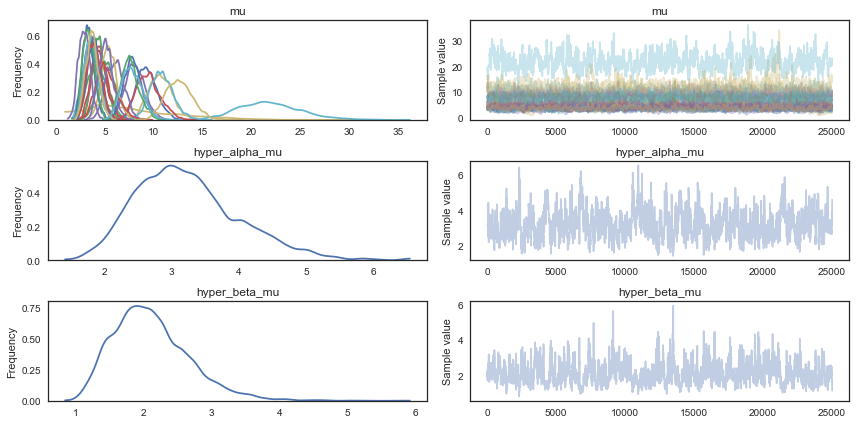

In [96]:
pm.traceplot(hierarchical_trace[25000:], varnames=['mu', 'hyper_alpha_mu', 'hyper_beta_mu'])

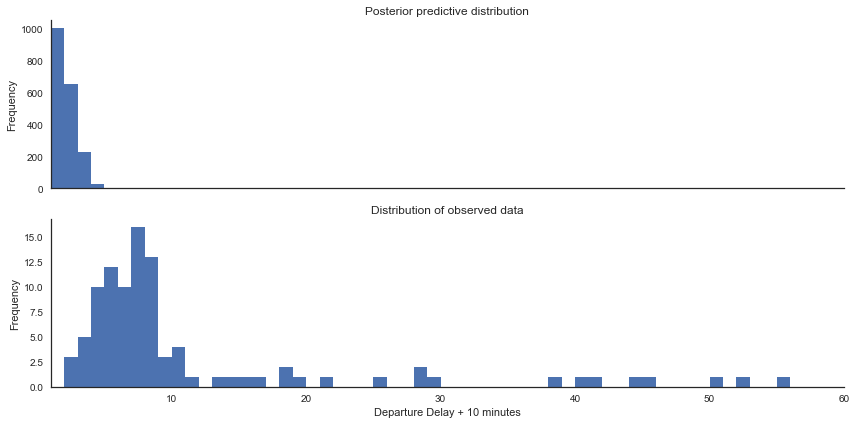

In [97]:
x_lim = 60
n_burn = 25000

y_pred = hierarchical_trace.get_values('y_pred')[n_burn::1000].ravel()

sns.set_style('white')
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))

ax[0].hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled')   
ax[0].set_xlim(1, x_lim)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Posterior predictive distribution')

ax[1].hist(local_shifted.DepDelay.values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
ax[1].set_xlabel('Departure Delay + 10 minutes')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of observed data')

sns.despine()

plt.tight_layout()
plt.show()